## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot_tools
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from library.utils import file_utils
from scipy.misc import toimage
%matplotlib inline

None


In [2]:
from sklearn import svm
from library.hog.hog import HOG

## Step 0: Parameters for the experiment

In [3]:
exp_no = 102
file_no = 6
one_hot = False
data_source = 'Website'
train_validate_split = 0.2
train_validate_split_data = None
num_images_required = 0.3
scale_method = 'StandardScaler'
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_svm_hog_cross_val/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

In [4]:
total_time = 0
svm_max_iter = 10000
svm_cs = 500
search_method = 'grid'
exp_jobs = 10
num_folds = 10

In [5]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
param_grid = [
    {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']},
    {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']},
]
param_name = 'exp_' + str(exp_no).zfill(3)

## Step 1: Load CIFAR 10 HOG dataset amd visualize CIFAR 10 dataset

In [6]:
block_size = (8,8)
cell_size = (4,4)
nbins = 9

In [7]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, image_mode='grey',
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 15000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 1.7394 seconds
[ Step 0] Dataset loaded in 1740.109205 ms
Dataset size: (15000, 3072)


Plotting CIFAR 10 Train Dataset


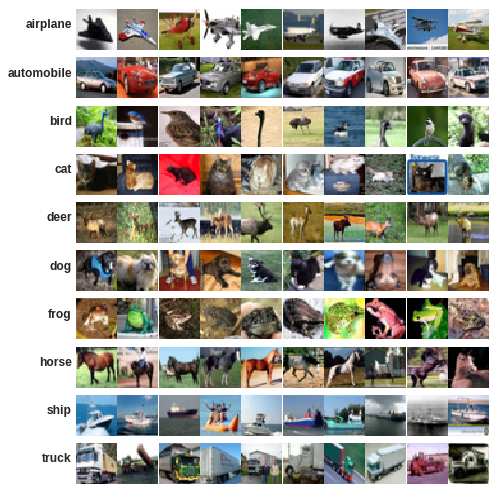

Plotting CIFAR 10 Test Dataset


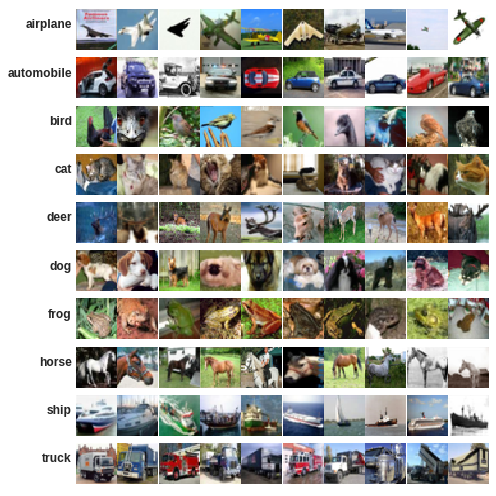

In [8]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

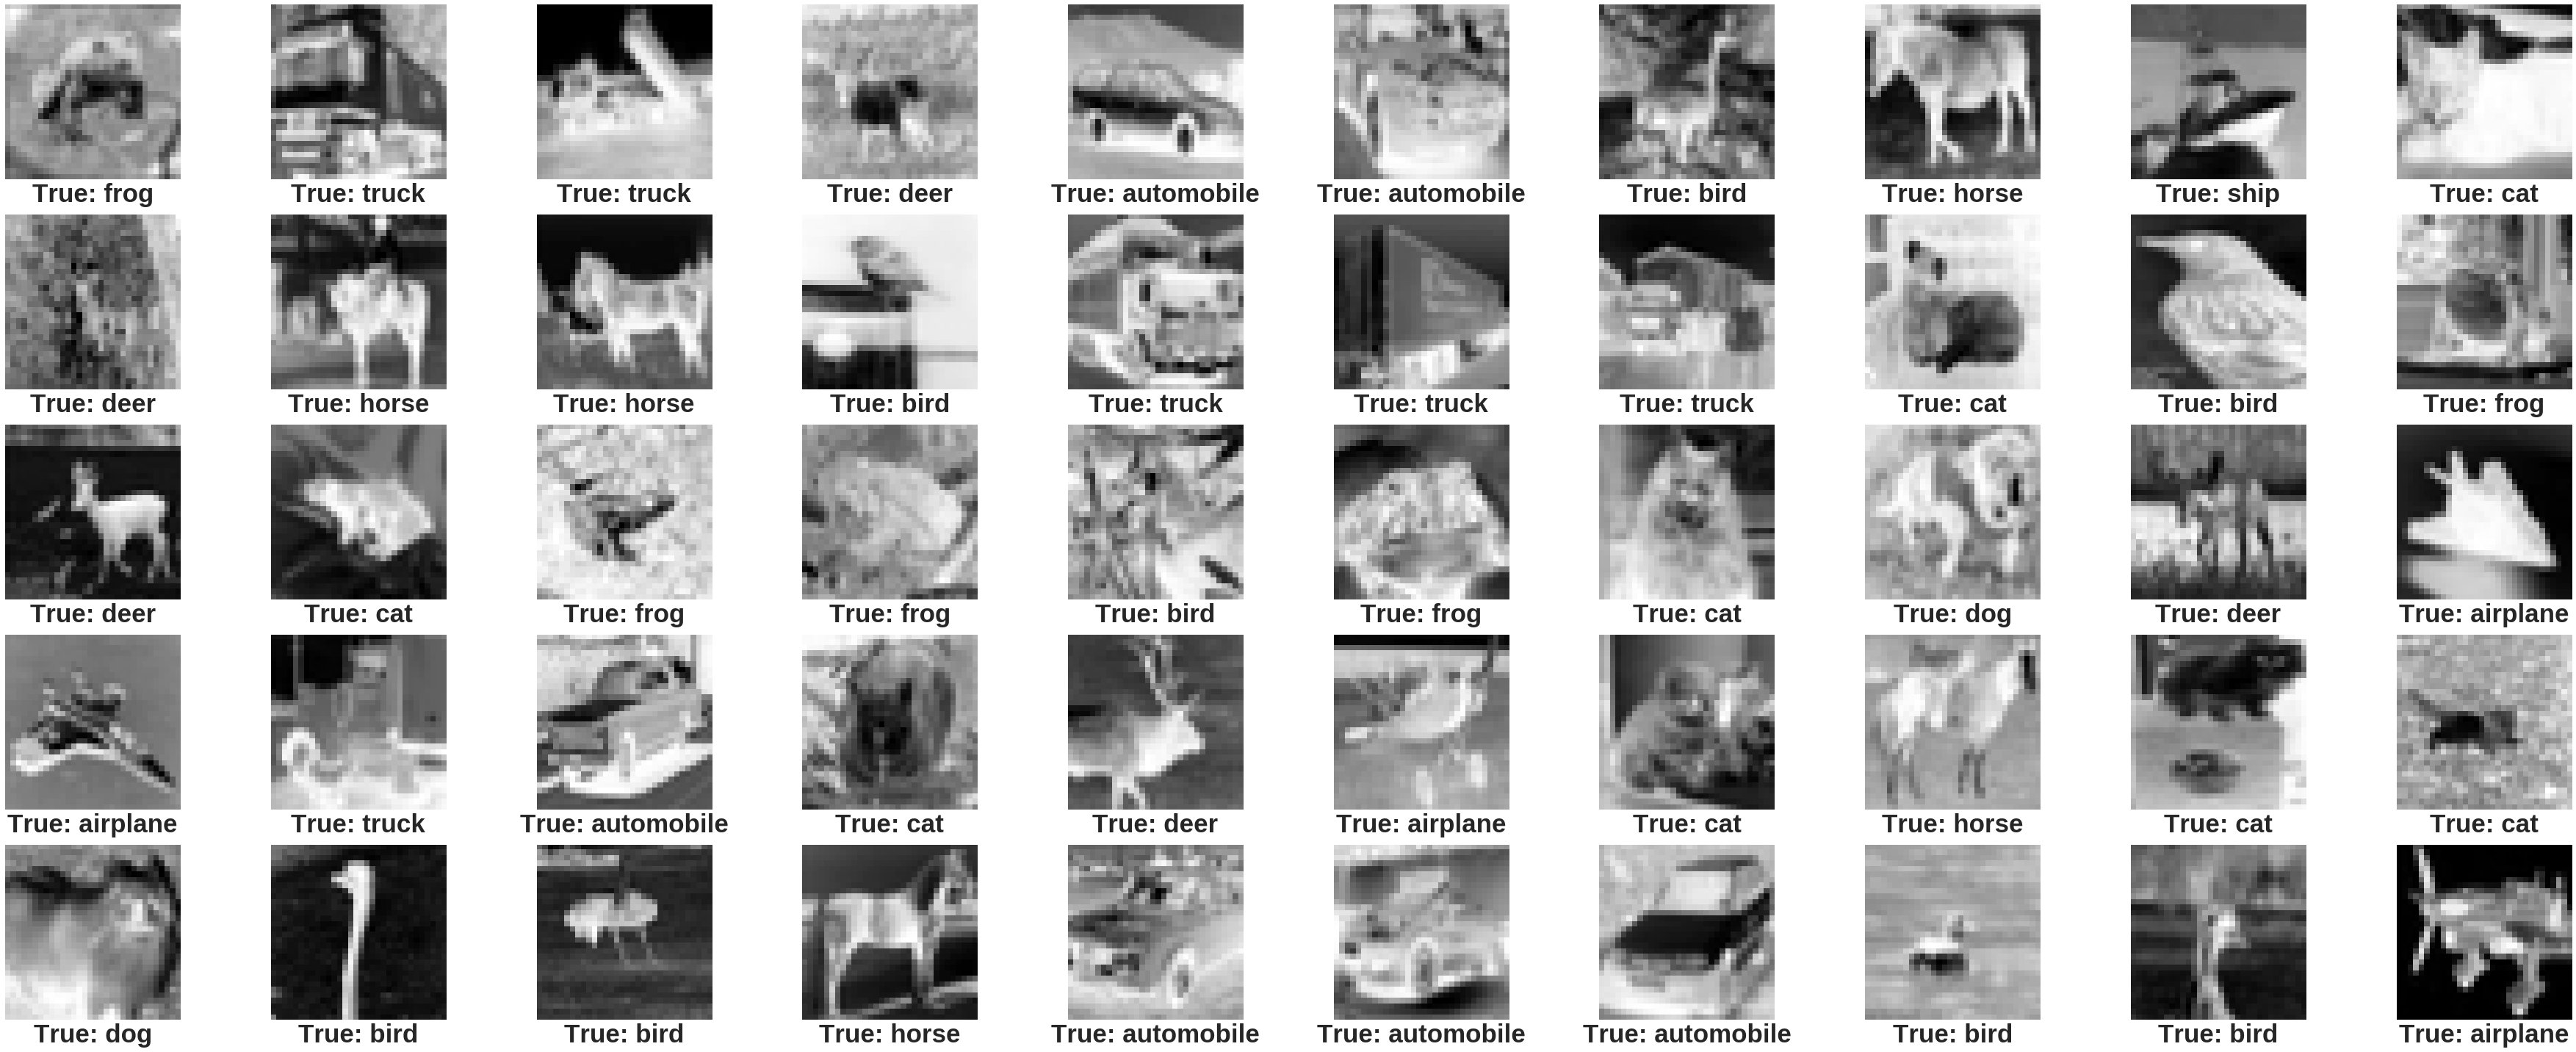

True

In [9]:
cifar10.plot_images(cifar10.train.images[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

## Step 1.1: Make CIFAR 10 HOG Train dataset

In [10]:
start = time.time()
data_hog = []
feature_size = 0
print('Block size     : ' + str(block_size))
print('Cell size      : ' + str(cell_size))
print('Number of bins : ' + str(nbins))
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Block size     : (8, 8)
Cell size      : (4, 4)
Number of bins : 9
Generating HOG features for 15000 data images
HOG Features for data: (15000, 576)
Generated HOG for train images in 7309.341669 ms


## Step 1.2: Make CIFAR 10 HOG Test dataset

In [11]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 576)
Generated HOG for test images in 4695.998669 ms


## Step 2: Preprocess data

In [12]:
start = time.time()
if scale_method == 'StandardScaler':
    ss = StandardScaler()
elif scale_method == 'MinMaxScaler':
    ss = MinMaxScaler()
else:
    ss = StandardScaler()
data_images = ss.fit_transform(data_hog)
test_images = ss.fit_transform(test_hog)
end = time.time()
print('[ Step 1] Dataset transformations done in %5.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(data_images.shape))
total_time += (end-start)

[ Step 1] Dataset transformations done in 204.220533 ms
Training the classifier on 15000 images
Dataset size: (15000, 576)


## Step 3: Parameters for estimating best model in SVM

In [13]:
print('Parameters to search for')
print('\n'.join([str(param) for param in param_grid])); print()

Parameters to search for
{'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
{'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']}
{'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']}



In [14]:
scores = []
scores_mean = []
scores_std = []

## Step 3.1: Run a search method for best parameters

In [15]:
svm_clf = svm.SVC(random_state=0, max_iter=svm_max_iter, cache_size=svm_cs, verbose=True)
print(svm_clf)

SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=True)


In [16]:
start = time.time()
if search_method == 'grid':
    print('Applying GridSearchCV')
    estimator = GridSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
elif serach_method == 'random':
    print('Applying RandomizedSearchCV')
    estimator = RandomizedSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', n_iter=10, 
                              random_state=0, verbose=3, n_jobs=exp_jobs)
else:
    print('Applying GridSearchCV')
    estimator = GridSearchCV(svm_clf, param_grid, cv=num_folds, scoring='accuracy', verbose=3, n_jobs=exp_jobs)
print(estimator)
estimator_result = estimator.fit(data_images, cifar10.train.class_labels)
end = time.time()
total_time += (end-start)
print('Total Time taken for cross validation and finding best parameters: %.4f ms' %((end-start)*1000))

Applying GridSearchCV
GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=True),
       fit_params={}, iid=True, n_jobs=10,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}, {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['poly']}, {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] C=1, gamma=0.1, kernel=rbf ............

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 17.9min


[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.349101, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.376744, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.348232, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.373582, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.358478, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.363393, total= 6.2min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[LibSVM][CV] ...... C=1, gamma=0.01, kernel=rbf, score=0.384102, total= 6.2min
[CV] C=1, gamma=0.001

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 83.3min


[LibSVM][CV] ... C=100, gamma=0.001, kernel=rbf, score=0.583556, total= 3.7min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[LibSVM][CV] ... C=100, gamma=0.001, kernel=rbf, score=0.588510, total= 3.8min
[CV] C=100, gamma=0.0001, kernel=rbf .................................


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.523588, total= 2.6min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.528277, total= 2.6min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.530233, total= 2.7min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.524317, total= 2.6min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.525684, total= 2.6min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.537742, total= 2.6min
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[LibSVM][CV] .. C=100, gamma=0.0001, kernel=rbf, score=0.534356, total= 2.6min
[CV] C=1000, gamma=0.

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.541639, total= 2.5min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.522924, total= 2.6min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.517631, total= 2.6min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.522924, total= 2.6min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.497665, total= 2.5min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.517011, total= 2.6min
[CV] C=1, gamma=0.01, kernel=poly ....................................
[LibSVM][CV] . C=1000, gamma=0.0001, kernel=rbf, score=0.536716, total= 2.6min
[CV] C=1, gamma=0.01,

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).

[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.465116, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.471058, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.463123, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.452365, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.473649, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.471648, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.489987, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.482966, total= 2.0min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.471610, total= 2.1min
[LibSVM][CV]  C=10, gamma=0.001, kernel=sigmoid, score=0.472594, total= 2.1min


[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 162.8min finished


[LibSVM]Total Time taken for cross validation and finding best parameters: 9906009.2649 ms


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [17]:
print('\n'.join('{}: {}'.format(k, v) for k, v in estimator.cv_results_.items())); print()
print('Scores for each set of parameters')
print('\n'.join([str(param) for param in estimator.grid_scores_])); print()
print('Best score')
print(estimator.best_score_); print()
print('Parameters corresponding to best score')
print(estimator.best_params_); print()

split0_test_score: [ 0.104  0.377  0.575  0.511  0.104  0.405  0.593  0.53   0.104  0.405  0.59   0.524  0.104  0.405  0.59   0.523  0.573  0.339  0.573  0.533  0.239  0.515  0.235  0.465]
split1_test_score: [ 0.104  0.36   0.595  0.522  0.104  0.379  0.591  0.546  0.104  0.379  0.59   0.53   0.104  0.379  0.59   0.523  0.6    0.363  0.6    0.576  0.277  0.52   0.274  0.463]
split2_test_score: [ 0.104  0.343  0.575  0.508  0.104  0.373  0.594  0.535  0.104  0.373  0.595  0.528  0.104  0.373  0.595  0.518  0.58   0.345  0.58   0.543  0.267  0.514  0.261  0.471]
split3_test_score: [ 0.103  0.349  0.572  0.486  0.103  0.38   0.6    0.509  0.103  0.38   0.603  0.524  0.103  0.38   0.603  0.542  0.596  0.354  0.596  0.562  0.253  0.486  0.248  0.452]
split4_test_score: [ 0.103  0.348  0.575  0.514  0.103  0.368  0.586  0.527  0.103  0.368  0.585  0.526  0.103  0.368  0.585  0.498  0.577  0.34   0.577  0.534  0.27   0.512  0.267  0.474]
split5_test_score: [ 0.103  0.374  0.591  0.525  0.103 

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## Step 3.1.1 Plot error lines showing +/- std. errors of the scores

In [18]:
means = estimator_result.cv_results_['mean_test_score']
stds = estimator_result.cv_results_['std_test_score']
params = estimator_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.103267 (0.000390) with: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.362333 (0.012698) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.582400 (0.010246) with: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.512800 (0.013188) with: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103667 (0.000875) with: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.389267 (0.013561) with: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.596933 (0.010638) with: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.537133 (0.013633) with: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103667 (0.000875) with: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.389267 (0.013561) with: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.597133 (0.011556) with: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.531533 (0.006005) with: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103667 (0.000875) with: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.389267 (0.013561) with: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.597133 (0.011556) with: {'C': 1000, '

## Step 4: Save the generated model to file

In [19]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '06_' + param_name + '.pkl'
joblib.dump(estimator, model_output_path)
end = time.time()
print('[ Step 4] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

[ Step 4] Write obtained model to ../logs/cifar10/06_svm_hog_cross_val/exp_no_102/06_exp_102.pkl in 87.001324 ms


In [20]:
scores = []
exp = []
dict_key = ['train', 'test']
for key in dict_key:
    scores_list = []
    for i in range(num_folds):
        key_name = 'split' + str(i) + '_' + key + '_score'
        scores_list.append(estimator.cv_results_[key_name].tolist())
    scores.append(scores_list)
scores = np.array(scores)
means = np.mean(np.array(scores).T, axis=1)
stds = np.std(np.array(scores).T, axis=1)

In [21]:
plot_tools.plot_variance(scores, means, stds, legend=['Training data', 'Validation data'], 
                         plot_title=['Train scores for best parameters for SVC using HOG features in CIFAR 10',
                                     'Validation scores for best parameters for SVC using HOG features in CIFAR 10'], 
                         fig_size=(800,600), 
                         plot_xlabel=['SVC Parameters', 'SVC Parameters'],
                         plot_ylabel=['Training accuracy of the model', 'Validation accuracy of the model'],
                         plot_lib='bokeh', 
                         matplotlib_style='default', bokeh_notebook=True)

Loading BokehJS ...

/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: Plot.background_fill was deprecated in Bokeh 0.11.0 and will be removed, use Plot.background_fill_color instead.
  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: Bo

## Step 5: Run the predictor on test data and generate predictions

In [22]:
start = time.time()
prediction_numbers = estimator.predict(test_images)
prediction_classes = []
num_test_images = test_images.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

[ Step 9] Make prediction on test dataset in 76589.935064 ms


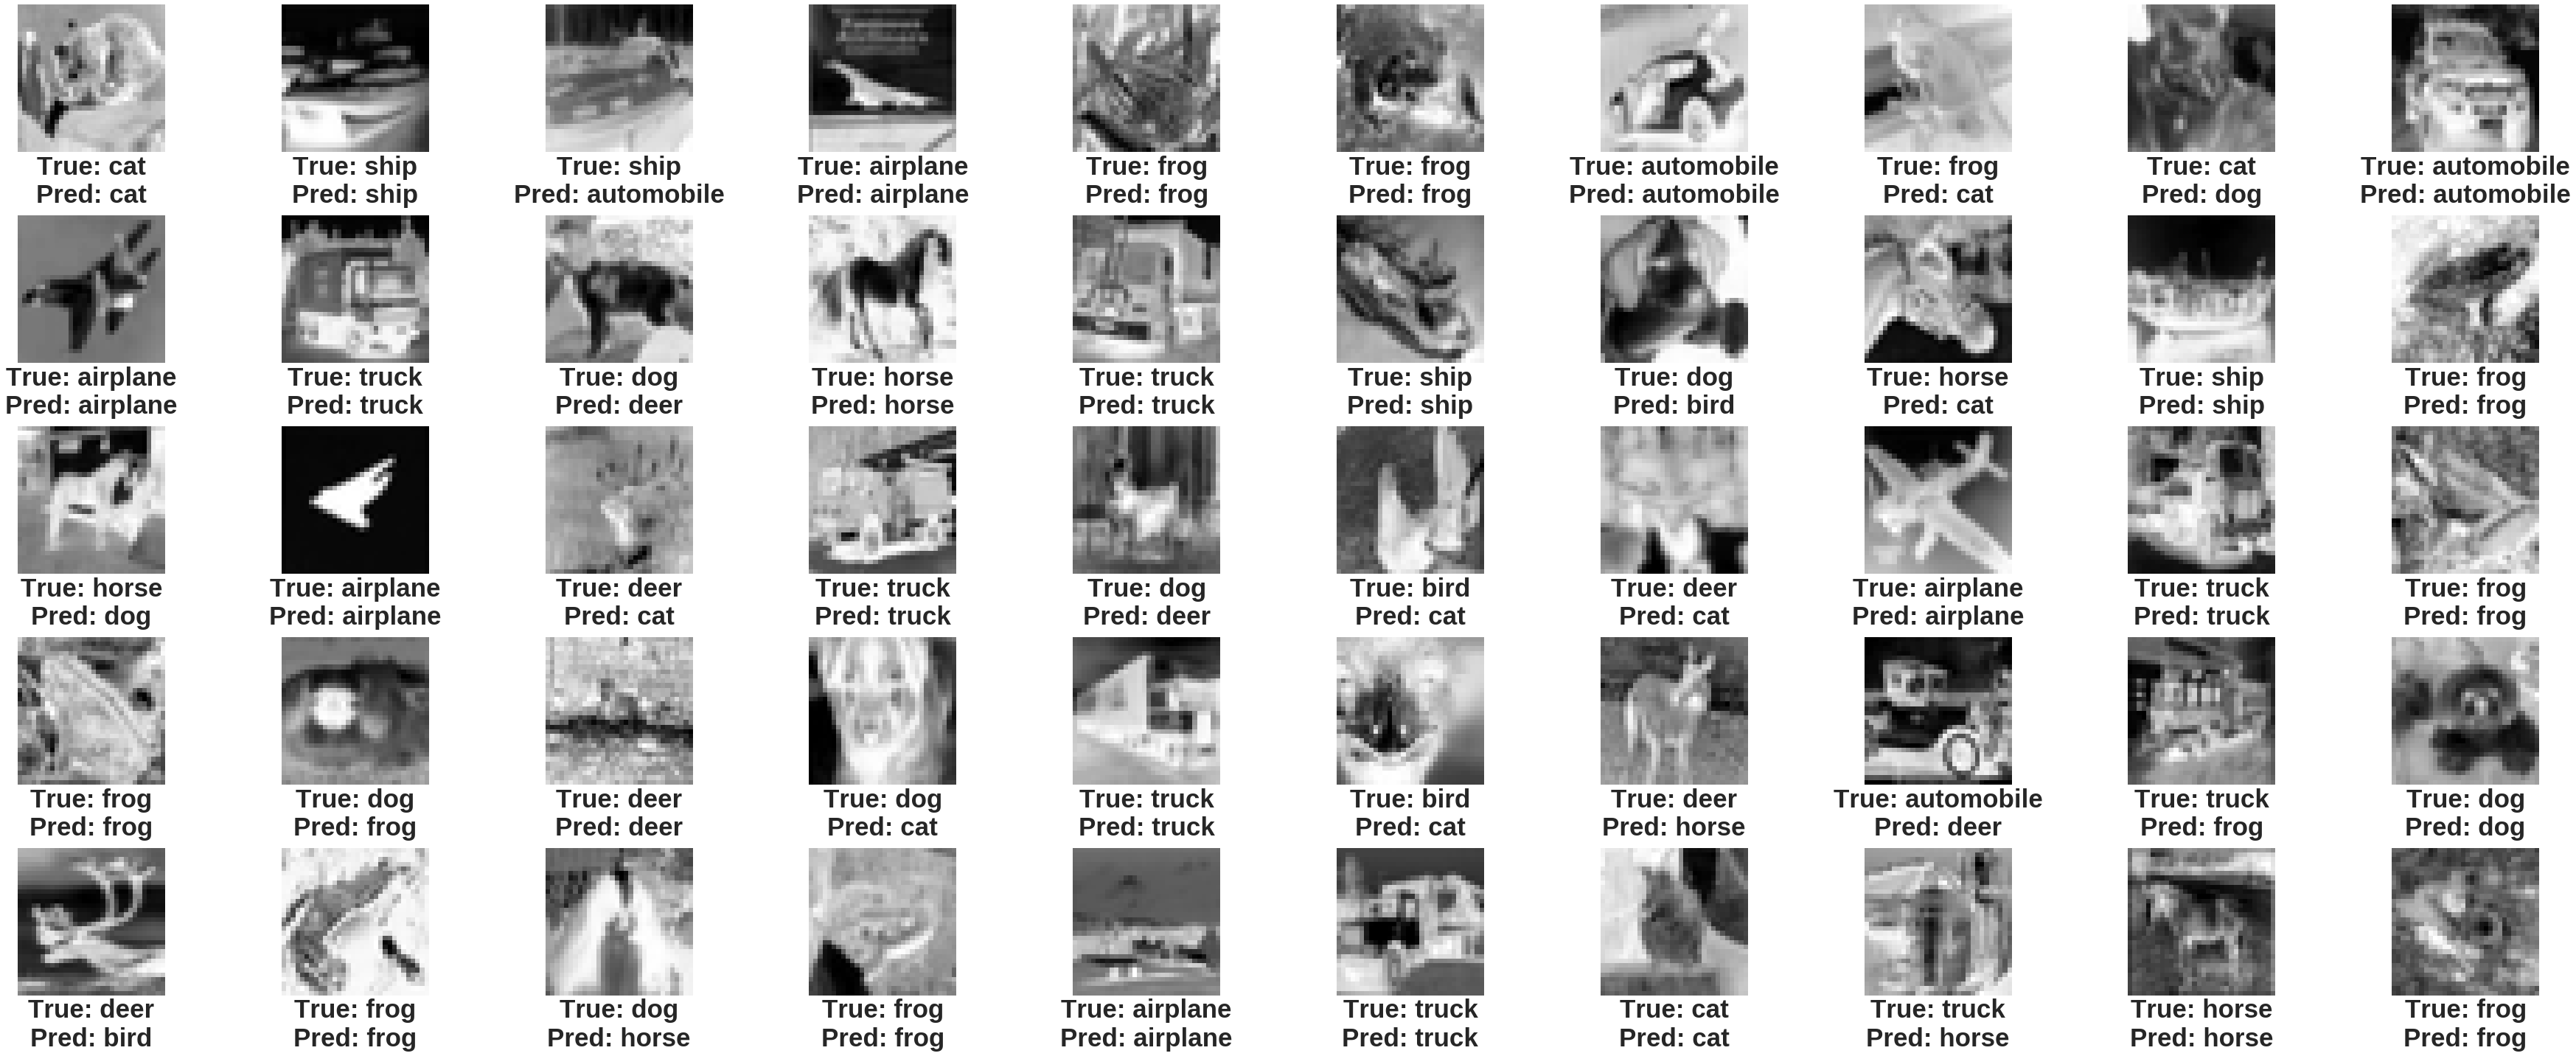

True

In [23]:
cifar10.plot_images(cifar10.test.images[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=False)

## Step 5.1 Print accuracy score of the classifier

Confusion matrix, without normalization
[[682  25  77  24  30   9  18  11 107  17]
 [ 40 747  13  19  24   4  25   6  48  74]
 [ 85  10 495  87  90  90  70  30  32  11]
 [ 44  25 102 406  88 143  85  54  16  37]
 [ 48  13  95 107 514  46  63  77  21  16]
 [ 20  12  98 217  62 459  51  63   9   9]
 [ 25  25  61  78  53  42 677  12  18   9]
 [ 20   7  57  61  84  73  17 643  13  25]
 [ 92  74  33  25  13   8  11  19 686  39]
 [ 33  75  14  32  21  24   8  34  54 705]]
Normalized confusion matrix
[[ 0.682  0.025  0.077  0.024  0.03   0.009  0.018  0.011  0.107  0.017]
 [ 0.04   0.747  0.013  0.019  0.024  0.004  0.025  0.006  0.048  0.074]
 [ 0.085  0.01   0.495  0.087  0.09   0.09   0.07   0.03   0.032  0.011]
 [ 0.044  0.025  0.102  0.406  0.088  0.143  0.085  0.054  0.016  0.037]
 [ 0.048  0.013  0.095  0.107  0.514  0.046  0.063  0.077  0.021  0.016]
 [ 0.02   0.012  0.098  0.217  0.062  0.459  0.051  0.063  0.009  0.009]
 [ 0.025  0.025  0.061  0.078  0.053  0.042  0.677  0.012  0.01

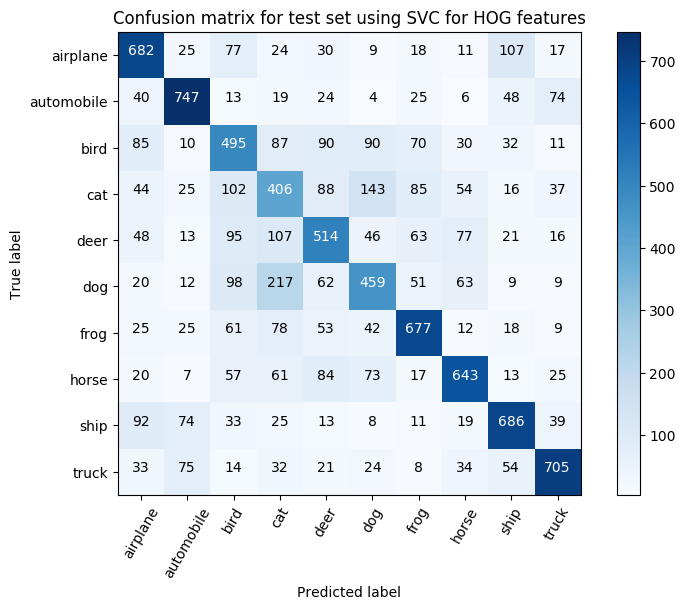

             precision    recall  f1-score   support

   airplane       0.63      0.68      0.65      1000
 automobile       0.74      0.75      0.74      1000
       bird       0.47      0.49      0.48      1000
        cat       0.38      0.41      0.39      1000
       deer       0.53      0.51      0.52      1000
        dog       0.51      0.46      0.48      1000
       frog       0.66      0.68      0.67      1000
      horse       0.68      0.64      0.66      1000
       ship       0.68      0.69      0.68      1000
      truck       0.75      0.70      0.73      1000

avg / total       0.60      0.60      0.60     10000

Accuracy score on test data: 0.6014


In [24]:
start = time.time()
plot_tools.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                              normalize=True, title='Confusion matrix for test set using SVC for HOG features')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [25]:
start = time.time()
print('Prediction done on %d images' %cifar10.test.data.shape[0])
print('Accuracy of the classifier: %.4f' %estimator.score(test_images, cifar10.test.class_labels))
end = time.time()
total_time += (end-start)

Prediction done on 10000 images
Accuracy of the classifier: 0.6014


## Step 6: Write predictions to csv file

In [26]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '06_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 6] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 6] Writing the test data to file: ../logs/cifar10/06_svm_hog_cross_val/exp_no_102/06_exp_102.csv in 12.004375 ms


## Step 7: Write notebook to HTML

In [27]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [28]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [31]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [32]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

Current file: ./06_CIFAR_10_SVM_HOG_Features_Cross_Validation.ipynb
Output file: ../logs/cifar10/06_svm_hog_cross_val/exp_no_102/06_exp_no_102_06_CIFAR_10_SVM_HOG_Features_Cross_Validation.html



In [33]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

Code took 10061.871141 s to run on training with 15000 examples
